In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import minimize_scalar
import matplotlib as mpl
from matplotlib import rc

#mpl.rcParams.update({'font.size': 16})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)
#rc('legend', fontsize=12)
mpl.rcParams['savefig.dpi'] = 1200
mpl.rcParams['text.usetex'] = True  # not really needed

#np.random.seed(0)

## theoretical

In [14]:
def get_coeff2(c_1, c_2, scale):
    d = (scale - 1.0/scale)**2
    coeff = [0 for i in range(4)]
    coeff[0] = -d  
    coeff[1] = d * (1 + (c_1 - 1.5)/(c_1 + c_2))
    coeff[2] = 1 - 1/(c_1 + c_2) - (1 - 1/(c_1 + c_2)) * ((c_1 - 0.5) / (c_1 + c_2)) * d
    coeff[3] = - (c_1/(c_1 + c_2)) * (1 - 1/(c_1 + c_2))**2
    A = np.roots(coeff)
    a_1 = -10
    num_valid = 0
    for a in A:
        if abs(np.imag(a)) <= 0.000001 and a > (c_1 - 1)/(c_1 + c_2) and a <= c_1/(c_1 + c_2) and a >= 0.0:
            if a != a_1: num_valid += 1            
            a_1 = a
    
#    print(A, num_valid)
    assert(num_valid == 1)
    a_2 = 1 - 1/(c_1 + c_2) - a_1
#    print(scale, c_1, c_2, A, a_1, a_2)
    return (a_1, a_2)

def te2(c_1, c_2, scale):
    if scale == 1:
        return 1/ (c_1 + c_2 - 1)
    
    # print(c_1, c_2, scale)
    a_1, a_2 = get_coeff2(c_1, c_2, scale)
    scale_sq = scale**2
    te = 0.5 / ((c_1 + c_2) * (scale_sq * a_1 + a_2))
    te += 0.5 / ((c_1 + c_2) * (a_1 / scale_sq + a_2))
    return te

# empirical

In [15]:
def te_target(X1, X2, beta_s, beta_t, w, sigma_2, Sigma2_sqrt):
    K = np.linalg.inv(w**2 * X1.T @ X1 + X2.T @ X2)
    beta_diff = beta_s - w * beta_t
    
    var = sigma_2**2 * np.trace(K @ Sigma2_sqrt @ Sigma2_sqrt)
    model_shift_bias = w**2 * np.linalg.norm(Sigma2_sqrt @ K @ X1.T @ X1 @ beta_diff) **2
    return model_shift_bias + var

def te_thy(c1_list, c2, scale, sigma):
    return sigma**2 * np.array([te2(c_1, c2, scale) for c_1 in c1_list])

In [16]:
def get_HPS_estimator(X1, Y1, X2, Y2):
    K = np.linalg.inv(X1.T @ X1 + X2.T @ X2)

    #print('test hps')
    #print(K.shape, X1.T.shape, Y1.shape, X2.T.shape, Y2.shape)
    
    return K @ (X1.T @ Y1 + X2.T @ Y2)

def te_target_emp(X1, X2, beta_t, sigma):

    Y1 = (X1 @ beta_t + np.random.normal(0, sigma, (X1.shape[0], 1))) 

    Y2 = (X2 @ beta_t + np.random.normal(0, sigma, (X2.shape[0], 1))) 

    #print(X1.shape, Y1.shape)

    beta_hps = get_HPS_estimator(X1, Y1, X2, Y2)

    emp_err = np.linalg.norm(beta_hps - beta_t)**2

    return emp_err

## Figure 2a: one line for each dimension

## p = 50, p = 100, p = 200

In [17]:
def get_results(c1_list, c2, p, sigma=0.5, scale=4):
    
    n2 = int(c2 * p)
    X2 = np.random.randn(n2, p)
    beta_t = np.random.randn(p, 1) / math.sqrt(p)
    beta_s = beta_t
    s_diag = scale * np.ones(p)
    for i in range(int(p/2), p):
        s_diag[i] = s_diag[i] / scale**2
    
    te_emp = []
    
    for c1 in c1_list:
        n1 = int(c1 * p)
        X1 = np.random.randn(n1, p) @ np.diag(s_diag)
        hat_w = 1
        if c1 == 0:
            te_beta_st = te_target(X1, X2, beta_s, beta_t, hat_w, sigma, np.eye(p))
        else:
            x = 0.0
            trials = 20
            for i in range(trials):
                x += te_target_emp(X1, X2, beta_t, sigma) # te_target(X1, X2, beta_s, beta_t, hat_w, sigma, np.eye(p)) # 
            te_beta_st = x / trials

        # print(te_beta_st)
        te_emp.append(te_beta_st)
            
    return te_emp

<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/var/folders/v8/8_pync_n0_vf_5wr12y0p8vh0000gn/T/ipykernel_46789/1913915021.py:24: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(c1_extended_list * p, te_the, c=colors[i], ls = linestyles[i], lw=linewidths[i], label=r'$\mathrm{Estimates}\ $' + r'$ (n_2 = \mathrm{'+str(n2)+'}$' + '$, p = \mathrm{'+str(p)+'})$')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


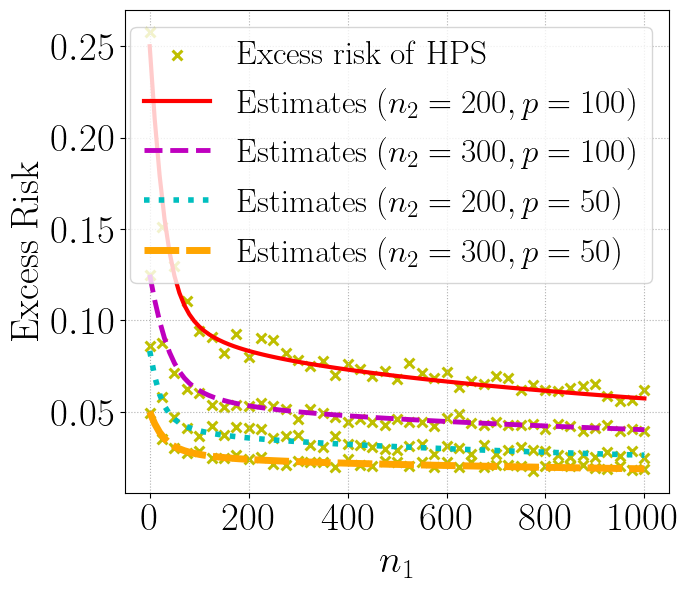

In [ ]:
#p = 200
#c2 = 4
sigma = 0.5

#test_points = [(100, 50)] # [(1, 50), (2, 50), (1, 100), (2, 100)]

plt.figure(figsize=(7,6))

colors = ['r', 'm', 'c', 'orange']
linestyles = ['solid', 'dashed', 'dotted', (0, (5, 1))]
linewidths = [3, 3.5, 4, 5]
i = 0

for n2, p in [(200, 100), (300, 100), (200, 50), (300, 50)]:
    c1_list = np.array([i * 25.0 / p for i in range(0, 41)])
    c1_extended_list = np.array([i * 10.0 / p for i in range(0, 101)])
    te_emp = get_results(c1_list, n2 / float(p), p)
    te_the = te_thy(c1_extended_list, n2 / float(p), 4, sigma)
    if i == 0:
        plt.scatter(c1_list * p, te_emp, marker='x', c='y',  s=50, lw=2.2, label=r'$\mathrm{Excess~risk~of~HPS}$')
    else:
        plt.scatter(c1_list * p, te_emp, marker='x', c='y',  s=50, lw=2.2)

    plt.plot(c1_extended_list * p, te_the, c=colors[i], ls = linestyles[i], lw=linewidths[i], label=r'$\mathrm{Estimates}\ $' + r'$ (n_2 = \mathrm{'+str(n2)+'}$' + '$, p = \mathrm{'+str(p)+'})$')
    i += 1
       
plt.xlabel(r'${n_1}$', fontsize=28)
plt.ylabel(r'$\mathrm{Excess~Risk}$', fontsize=28)
#axes = plt.gca()
#axes.set_xlim([1.0, 20.0])

plt.yticks(fontsize=28)
plt.xticks(fontsize=28)
#plt.xlim([500, 4000])
#plt.ylim([0.01, 0.05])

plt.grid(ls = ':', lw=0.8)
plt.legend(fontsize=22)#,loc=3)
plt.tight_layout()
plt.savefig('verify_covariate_shift.eps')

## Figure 2b: one line for each covariate shift setting

In [19]:
p = 100
c_2 = 3
n2 = c_2 * p
sigma = 0.5

# covariates
X2 = np.random.randn(n2, p)

# models
beta_t = np.random.randn(p, 1) / math.sqrt(p)

# labels
Y2 = X2 @ beta_t + sigma * np.random.randn(n2, 1)

c1_list = np.array([i * 25.0 / p for i in range(0, 41)])
c1_extended_list = np.array([i * 10.0 / p for i in range(0, 101)])
scale_list = [1, 2, 4, 10]

te_mtl_list = []

beta_s = beta_t

for s in scale_list:
    s_diag = s * np.ones(p)
    for i in range(int(p/2), p):
        s_diag[i] = s_diag[i] / s**2

    for c1 in c1_list:
        n1 = int(c1 * p)
        X1 = np.random.randn(n1, p) @ np.diag(s_diag)

        hat_w = 1
        x = 0.0
        trials = 30
        for i in range(trials):
            x += te_target_emp(X1, X2, beta_t, sigma) # te_target(X1, X2, beta_s, beta_t, hat_w, sigma, np.eye(p)) # 
        te_beta_st = x / trials
        #te_beta_st = te_target(X1, X2, beta_s, beta_t, hat_w, sigma, np.eye(p))

        te_mtl_list.append(te_beta_st)

KeyboardInterrupt: 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


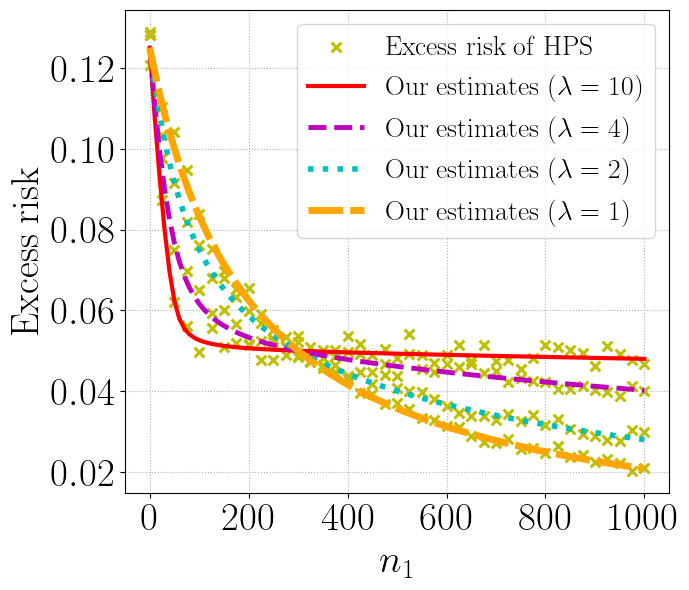

In [ ]:
te_emp_list = [te_mtl_list[:41], te_mtl_list[41:82], te_mtl_list[82:123], te_mtl_list[123:164]]

#print(te_emp_list)

te_list = sigma**2 * np.array([[te2(c_1, c_2, scale) for c_1 in c1_extended_list] for scale in scale_list])
#print(te_list)

plt.figure(figsize=(7,6))
colors = ['r', 'm', 'c', 'orange']


for i, ts in enumerate(te_list):
    if i == 3:
        plt.scatter(c1_list * p, te_emp_list[i], marker='x', c='y',  s=50, lw=2.2, label=r'$\mathrm{Excess~risk~of~HPS}$')
        plt.plot(c1_extended_list * p, ts, c=colors[0], ls=linestyles[0], lw=linewidths[0], label=r'$\mathrm{Estimates}\ $' + r'$(\lambda = 10)$')

for i, ts in enumerate(te_list):        
    if i == 2:
        plt.scatter(c1_list * p, te_emp_list[i], marker='x', c='y',  s=50, lw=2.2)
        plt.plot(c1_extended_list * p, ts, c=colors[1], ls=linestyles[1], lw=linewidths[1], label=r'$\mathrm{Estimates}$\ ' + r'$(\lambda = 4)$')

for i, ts in enumerate(te_list):        
    if i == 1:
        plt.scatter(c1_list * p, te_emp_list[i], marker='x', c='y', s=50, lw=2.2)
        plt.plot(c1_extended_list * p, ts, c=colors[2], ls=linestyles[2], lw=linewidths[2], label=r'$\mathrm{Estimates}\ $' + r'$(\lambda = 2)$')
        
for i, ts in enumerate(te_list):        
    if i == 0:
        plt.scatter(c1_list * p,  te_emp_list[i], marker='x', c='y', s=50, lw=2.2)
        plt.plot(c1_extended_list * p, ts, c=colors[3], ls=linestyles[3], lw=linewidths[3], label=r'$\mathrm{Estimates}\ $' + r'$(\lambda = 1)$')
        
plt.xlabel(r'$n_1$', fontsize=28)
plt.ylabel(r'$\mathrm{Excess~Risk}$', fontsize=28)
#plt.title(r'$\lambda$' + r'$\mathrm{: ~Severity~of~covariate~shift}$', fontsize=24)
#axes = plt.gca()
#axes.set_xlim([1.0, 20.0])

plt.yticks(np.arange(0.02, 0.13, 0.02), fontsize=28)
plt.xticks(np.arange(0, 1100, 200), fontsize=28)
#plt.xlim([500, 4000])
#plt.ylim([0.01, 0.05])

plt.grid(ls = ':', lw=0.8)
plt.legend(fontsize=22)#,loc=3)
plt.tight_layout()
plt.savefig('covariate_shift.eps')

In [ ]:
c1_list = np.array([i * 100.0 / p for i in range(0, 11)])
c1_extended_list = np.array([i * 10.0 / p for i in range(0, 101)])
